In [3]:
#Install Pyspark
!pip install pyspark
!pip install findspark

In [4]:
import findspark
findspark.init
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import StructType,StringType,IntegerType,MapType,ArrayType,StructField
from pyspark.sql.functions import count,when,col,isnan,from_json,explode,map_keys,udf,coalesce,lit,to_date,year,split,get_json_object,array,collect_list,concat_ws,regexp_replace,regexp_extract
from pyspark.sql.functions import row_number,lit
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import os



In [5]:
#Start Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

/opt/conda/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [6]:
# Input data files are available in the read-only "../input/" directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv
/kaggle/input/top-500-hollywood-movies-of-all-time/Most Profitable Movies of All Time - Top 500 Movies.csv


In [7]:
from tqdm import tqdm

# Define all file names and their corresponding variable names
file_info = {
    "links": "links.csv",
    "keywords": "keywords.csv",
    "movies_metadata": "movies_metadata.csv",
    "credits": "credits.csv",
    "ratings": "ratings.csv",
    "ratings_sample": "ratings_small.csv"
}

# Store results
datasets = {}

# Load datasets with tqdm progress bar
for name in tqdm(file_info, desc="Loading CSV files with Spark"):
    datasets[name] = spark.read\
        .format("com.databricks.spark.csv")\
        .option("multiline", True)\
        .option("header", True)\
        .option("escape", "\"")\
        .option("inferSchema", True)\
        .csv(f"../input/the-movies-dataset/{file_info[name]}")

# Assign to variables
links = datasets["links"]
keywords = datasets["keywords"]
movies_metadata = datasets["movies_metadata"]
credits = datasets["credits"]
ratings = datasets["ratings"]
ratings_sample = datasets["ratings_sample"]

Loading CSV files with Spark: 100%|██████████| 6/6 [00:36<00:00,  6.04s/it]


In [8]:
credits.printSchema()

root
 |-- cast: string (nullable = true)
 |-- crew: string (nullable = true)
 |-- id: integer (nullable = true)



In [9]:
keywords.printSchema()

root
 |-- id: integer (nullable = true)
 |-- keywords: string (nullable = true)



In [10]:
links.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [11]:
movies_metadata.printSchema()

root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: double (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: boolean (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nu

In [12]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [13]:
schema=StructType().add("fileName",StringType(),nullable=True).add("fileCount",IntegerType(),nullable=True).add('noOfColumns',IntegerType(),nullable=True)

dataDictionary=[('Credits.csv',credits.count(),len(credits.columns)),('Keywords.csv',keywords.count(),len(keywords.columns))
,('links.csv',links.count(),len(links.columns)),('Movies_metadata.csv',movies_metadata.count(),len(movies_metadata.columns)),
('Ratings.csv',ratings.count(),len(ratings.columns))]

df = spark.createDataFrame(data=dataDictionary, schema =schema )
df.show()

+-------------------+---------+-----------+
|           fileName|fileCount|noOfColumns|
+-------------------+---------+-----------+
|        Credits.csv|    45476|          3|
|       Keywords.csv|    46419|          2|
|          links.csv|    45843|          3|
|Movies_metadata.csv|    45466|         24|
|        Ratings.csv| 26024289|          4|
+-------------------+---------+-----------+



In [14]:
movies_metadata=movies_metadata.where(~col('id').isin('82663','162372','215848'))# drop few corrupted #records

#drop rows which have null values in the Json column - "production_companies","production_countries"
movies_metadata=movies_metadata.na.drop(subset=["production_companies","production_countries","genres"])




Columns 'production_countries','production_companies','genres' have Json format data. There are many rows where these columns value is '[]'. We will replace '[]' to 'Unknwon' to avoid any Json parsing issues.

In [15]:
movies_metadata=movies_metadata.withColumn('genres',when(col('genres')=='[]',"[{'id': 0, 'name': 'Unknown'}]").otherwise(col('genres')))\
               .withColumn('production_companies',when(col('production_companies')=='[]',"[{'name': 'Unknown', 'id': 0}]").otherwise(col('production_companies')))\
               .withColumn('production_countries',when(col('production_countries')=='[]',"[{'iso_3166_1': 'Unknown', 'name': 'Unknown'}]").otherwise(col('production_countries')))


In [16]:
datadict={'Ratings.csv':ratings,'Movies_metadata.csv':movies_metadata,'Credits.csv':credits,'Keywords.csv':keywords,'links.csv':links}

for key,value in datadict.items() :
  dfStats= value.select([count(when(col(c).isNull()|isnan(c),'True')).alias(c) for c,c_type in value.dtypes if c_type not in ('timestamp','boolean')])
  print("Column stats for data file :" +key+"\n")
  dfStats.show()

Column stats for data file :Ratings.csv

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

Column stats for data file :Movies_metadata.csv

+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+----------------+------+-------+-----+------------+----------+
|adult|belongs_to_collection|budget|genres|homepage| id|imdb_id|original_language|original_title|overview|popularity|poster_path|production_companies|production_countries|release_date|revenue|runtime|spoken_languages|status|tagline|title|vote_average|vote_count|
+-----+---------------------+------+------+--------+---+-------+-----------------+--------------+--------+----------+-----------+--------------------+--------------------+------------+-------+-------+-------------

In [17]:
#Change Column data type
movies_metadata=movies_metadata.withColumn('budget',col('budget').cast('integer'))\
                               .withColumn('popularity',col('popularity').cast('float'))\
                               .withColumn('revenue',col('revenue').cast('integer'))

In [18]:
# identify duplicates based on IMDB ID
df_dup=movies_metadata.groupby('imdb_id','title','release_date', 'overview').count().filter("count > 1").show()

#Total number of duplicate rows
movies_metadata.groupby('imdb_id','title','release_date', 'overview').count().where(f.col('count')>1).select(f.sum('count')).show()

# DROP Duplicates - using drop_duplicates - RETURNS NEW DF
movies_metadata=movies_metadata.drop_duplicates(['imdb_id','title','release_date', 'overview'])

+---------+--------------------+------------+--------------------+-----+
|  imdb_id|               title|release_date|            overview|count|
+---------+--------------------+------------+--------------------+-----+
|tt0454792|              Bubble|  2005-09-03|Set against the b...|    2|
|tt0287635|Pokémon 4Ever: Ce...|  2001-07-06|All your favorite...|    2|
|tt1821641|        The Congress|  2013-05-16|More than two dec...|    2|
|tt0270288|Confessions of a ...|  2002-12-30|Television made h...|    2|
|tt1180333|            Blackout|  2008-12-26|Recovering from a...|    3|
|tt0022537|          The Viking|  1931-06-21|Originally called...|    2|
|tt1701210|          Black Gold|  2011-12-21|On the Arabian Pe...|    2|
|tt0499456|    Days of Darkness|  2007-01-01|When a comet stri...|    2|
|tt0084387|Nana, the True Ke...|  1983-06-13|In Zola's Paris, ...|    2|
|tt0157472|       Clockstoppers|  2002-03-17|Until now, Zak Gi...|    2|
|tt2121382|       Force Majeure|  2014-08-15|While 

In [19]:
movies_metadata.toPandas().head(10)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,None,0.0,"[{'id': 0, 'name': 'Unknown'}]",None,45514,None,en,8,8 shorts centered around 8 themes directed by ...,...,2008-10-23,0.0,100.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Rumored,None,8,False,0.0,0.0
1,False,None,0.0,"[{'id': 0, 'name': 'Unknown'}]",None,118013,None,en,Endeavour,Shaun Evans (The Take) steps into John Thaw's ...,...,None,0.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Rookie detective Endeavor Morse faces his firs...,Endeavour,False,6.6,19.0
2,False,None,0.0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 12, 'na...",None,65256,None,en,H2O Just Add Water - The Movie,When three normal teenage girls stumble upon a...,...,2011-10-10,0.0,91.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Do you believe in mermaids?,H2O Just Add Water - The Movie,False,6.4,37.0
3,False,"{'id': 75014, 'name': 'How I Unleashed World W...",0.0,"[{'id': 10769, 'name': 'Foreign'}, {'id': 28, ...",None,75015,None,pl,Jak rozpętałem drugą wojnę światową: Cz.3 - Wś...,How I Unleashed World War II tells the story o...,...,1970-04-06,0.0,73.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Released,None,How I Unleashed World War II Part III: Among F...,False,7.0,3.0
4,False,None,0.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",None,293412,None,en,Running Wild,Jennifer Barker plays a troubled woman who has...,...,1995-01-01,0.0,0.0,[],Released,None,Running Wild,False,10.0,1.0
5,False,None,0.0,"[{'id': 18, 'name': 'Drama'}]",None,16624,tt0000005,xx,Blacksmith Scene,Three men hammer on an anvil and pass a bottle...,...,1893-05-08,0.0,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,None,Blacksmith Scene,False,5.8,19.0
6,False,None,0.0,"[{'id': 35, 'name': 'Comedy'}]",None,82120,tt0000014,fr,Arroseur et arrosé,"A gardener is watering his flowers, when a mis...",...,1895-12-27,0.0,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,None,Tables Turned on the Gardener,False,7.0,44.0
7,False,None,0.0,"[{'id': 99, 'name': 'Documentary'}]",None,129865,tt0000070,fr,Démolition d'un mur,Auguste Lumière directs four workers in the de...,...,1896-03-06,0.0,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,None,Demolition of a Wall,False,5.8,17.0
8,False,None,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",None,104462,tt0000131,fr,Une nuit terrible,"A man tries to get a good night's sleep, but i...",...,1896-01-01,0.0,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,None,A Terrible Night,False,6.2,13.0
9,False,None,0.0,"[{'id': 0, 'name': 'Unknown'}]",None,159900,tt0000192,en,"Ella Lola, a la Trilby","A young, dark-haired woman performs a dance in...",...,1898-01-01,0.0,1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,None,"Ella Lola, a la Trilby",False,4.0,1.0


In [20]:
movies_metadata=movies_metadata.withColumnRenamed("id","id_ori")\
                                .withColumnRenamed("poster_path","poster_path_ori")

#Attach schema to Json object column
df=movies_metadata.withColumn("belongs_to_collection_value",from_json(movies_metadata.belongs_to_collection,MapType(StringType(),StringType())))
                  

# Get the distinct Keys of Json object
key_df=df.select(explode(map_keys(col('belongs_to_collection_value')))).distinct()

# Convert Key collection object to a List
keylst=list(map(lambda row:row[0],key_df.collect()))

#Retrive values based on Keys into a seperate column
key_cols=map(lambda f:df['belongs_to_collection_value'].getItem(f).alias(str(f)),keylst)
#df2=df2.select(col('belongs_to_collection'),*key_cols)
df=df.select(*movies_metadata.columns,*key_cols)
df.printSchema()

root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id_ori: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- poster_path_ori: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: double (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: boolean (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: 

As shown above, 'belongs_to_collection' is parsed and four new columns  'name','poster_path','backdrop_path' and 'id' are added to dataframe.

In [21]:
# Columns - production_companies , production_countries , genres have Json array values


#Step 1 - Define  schema of Json array type
schema = ArrayType(StructType([
        StructField('id', IntegerType(), nullable=False), 
        StructField('name', StringType(), nullable=False)]))

#Step 2 - UDF function to convert list to column seperated values. As Data is in Json array, extracting 
#values based on Json keys will  produce list
convertUDF = udf(lambda s: ','.join(map(str, s)),StringType())

#Step 3 - Json parsing
df=df.withColumn("production_companies_values",when(col('production_companies')=='[]','').otherwise(convertUDF(from_json(movies_metadata.production_companies,schema).getField("name"))))\
     .withColumn("production_countries_values",convertUDF(from_json(movies_metadata.production_countries,schema).getField("name")))\
     .withColumn("genres_value",convertUDF(from_json(movies_metadata.genres,schema).getField("name")))

df.select('id_ori',"genres_value","production_companies_values","production_countries_values").show(10,False)

+------+-----------------------------+----------------------------+---------------------------+
|id_ori|genres_value                 |production_companies_values |production_countries_values|
+------+-----------------------------+----------------------------+---------------------------+
|45514 |Unknown                      |Unknown                     |France                     |
|118013|Unknown                      |Unknown                     |Unknown                    |
|65256 |Fantasy,Adventure            |ZDF Enterprises             |Australia                  |
|75015 |Foreign,Action,History,Comedy|Unknown                     |Poland                     |
|293412|Adventure,Drama              |Unknown                     |Unknown                    |
|16624 |Drama                        |Edison Manufacturing Company|United States of America   |
|82120 |Comedy                       |Lumière                     |France                     |
|129865|Documentary                  |Lu

In [22]:
df.select('runtime','budget','revenue','vote_average','vote_count','popularity')\
  .summary("count", "min", "25%", "75%", "max").show()

+-------+-------+---------+-----------+------------+----------+----------+
|summary|runtime|   budget|    revenue|vote_average|vote_count|popularity|
+-------+-------+---------+-----------+------------+----------+----------+
|  count|  45171|    45428|      45428|       45428|     45428|     45428|
|    min|    0.0|        0|-1507002209|         0.0|         0|       0.0|
|    25%|   85.0|        0|          0|         5.0|         3|  0.385825|
|    75%|  107.0|        0|          0|         6.8|        34|  3.676921|
|    max| 1256.0|380000000| 2068223624|        10.0|     14075|  547.4883|
+-------+-------+---------+-----------+------------+----------+----------+



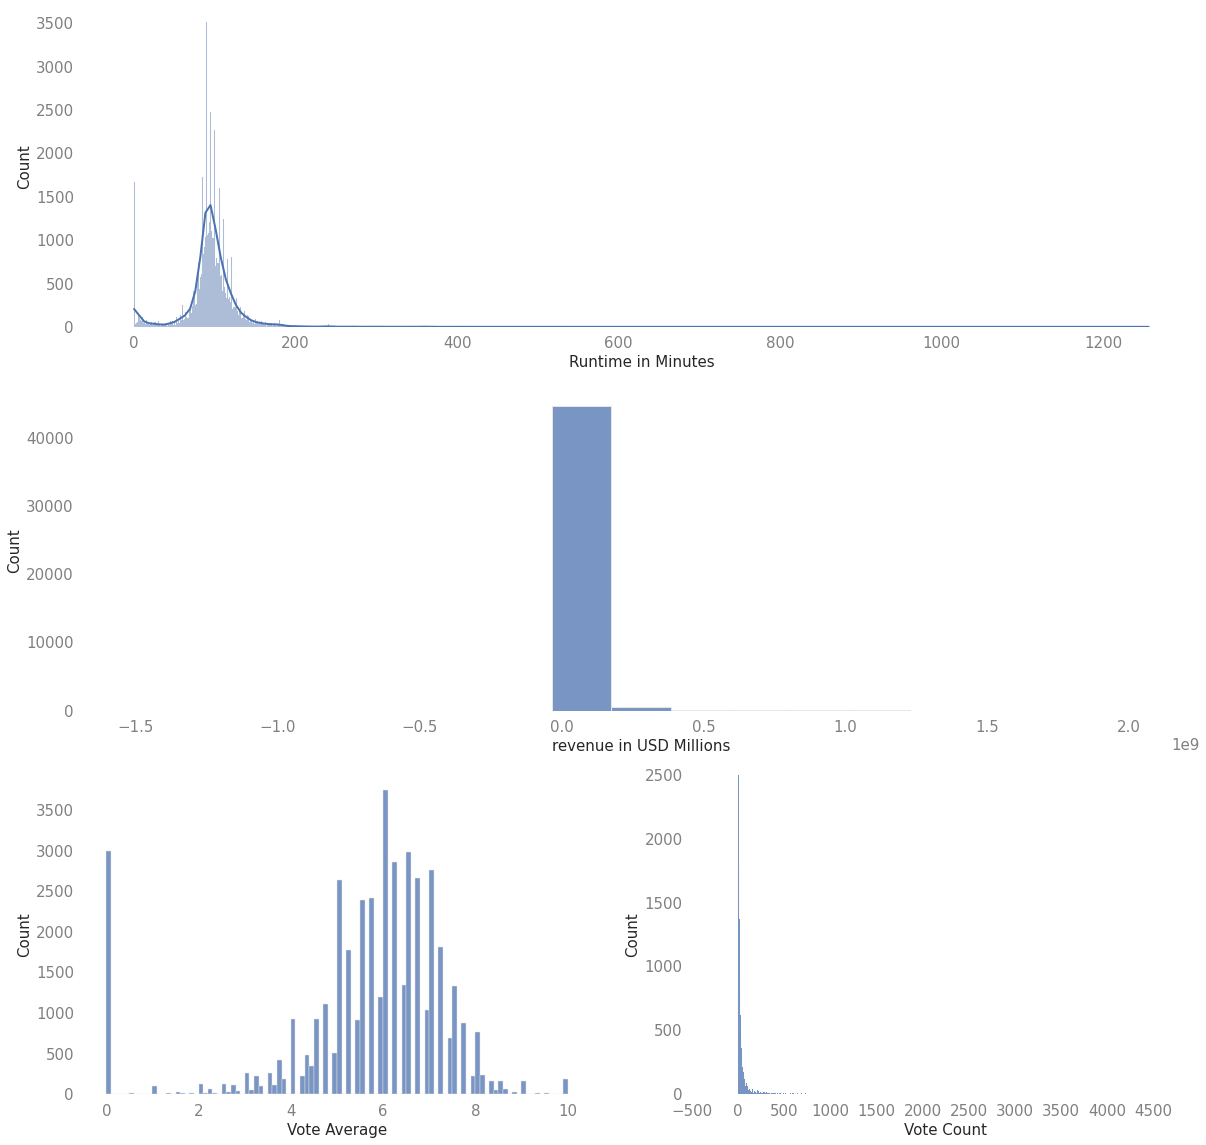

In [24]:
df_pd=df.select("runtime","revenue","vote_average","vote_count").toPandas()


from matplotlib import cycler

# sns.set_theme(style="whitegrid")

# # 2) tweak rcParams
# plt.rcParams.update({
#     'figure.facecolor':  'white',
#     'axes.facecolor':    'white',
#     'axes.edgecolor':    'black',        # show border
#     'axes.linewidth':    3,             # border thickness
#     'grid.color':        '#EEEEEE',     # subtle grid
#     'grid.linestyle':    'solid',
#     'lines.linewidth':   3,
#     'xtick.color':       'gray',
#     'ytick.color':       'gray',
#     'xtick.direction':   'out',
#     'ytick.direction':   'out',
#     'axes.labelsize':    15,
#     'xtick.labelsize':   15,
#     'ytick.labelsize':   15,
# })

colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#ffffff', edgecolor='none',
       axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')

plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.rc(('xtick', 'ytick'), labelsize=15)
plt.rcParams['axes.labelsize'] = 15


fig = plt.figure(figsize=(20,20))
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.2)


f1=sns.histplot(data=df_pd ,x="runtime", kde=True,ax=fig.add_subplot(grid[0, :]))
f1.set_xlabel('Runtime in Minutes')

f2=sns.histplot(data=df_pd ,x="revenue", kde=False,ax=fig.add_subplot(grid[1,:]))
f2.set_xlabel('revenue in USD Millions')

f3=sns.histplot(data=df_pd ,x="vote_average", kde=False,ax=fig.add_subplot(grid[2,:1]))
f3.set_xlabel('Vote Average')

f3=sns.histplot(data=df_pd ,x="vote_count", kde=False,ax=fig.add_subplot(grid[2,1]))
f3.set_xlabel('Vote Count')
f3.set_xlim(0,5000)
f3.xaxis.set_ticks(np.arange(-500, 5000, 500))
f3.set_ylim(0,2500)

plt.show()

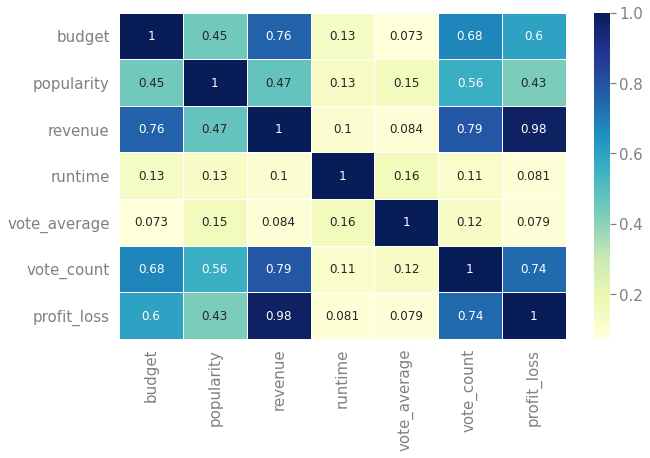

In [25]:
data_for_corr=df.select('budget','popularity','revenue','runtime','vote_average','vote_count')\
                              .withColumn("profit_loss",coalesce(col('revenue'),lit(0))-coalesce(col('budget'),lit(0)))

data_for_corr_pd=data_for_corr.toPandas().dropna(how='any')# convert to Pandas dataframe and rows which has null values



correlations = data_for_corr_pd.corr()
f,ax = plt.subplots(figsize=(10,6))
sns.heatmap(correlations, annot=True, cmap="YlGnBu", linewidths=.5)

plt.show()

Movies profit/loss has significant correlation with movie budgets. This means that a better technical quality movies help in bringing audiences to movie halls. Higher number of user votes also indicates movie popularity among audeinces.

<a id="4.6"></a> <br>
<h2>Top 10 voted movies</h2>

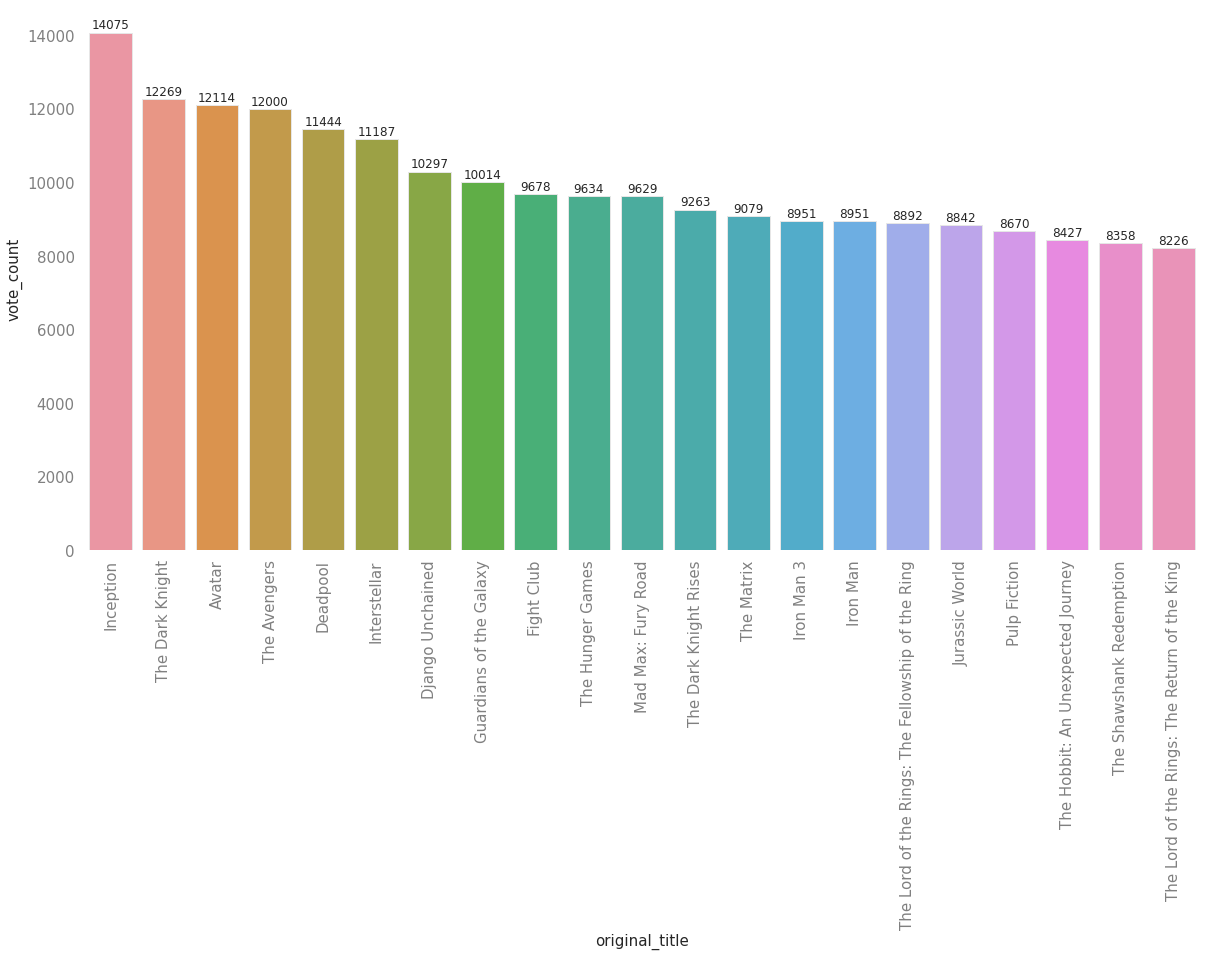

In [26]:
df_pd_votecount=df.select('original_title','vote_count','vote_average').toPandas()
df_pd_votecount=df_pd_votecount.sort_values(by='vote_count',ascending=False).iloc[0:21,:].reset_index(drop=True)

fig = plt.figure(figsize=(20,10))
ax=plt.subplot(111)
bar_plot=sns.barplot(x=df_pd_votecount['original_title'],y=df_pd_votecount['vote_count'],ax=ax)
for tick in bar_plot.get_xticklabels():
    tick.set_rotation(90)


def _show_on_single_plot(ax):        
        for p in bar_plot.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()+100
            value =format(int(p.get_height()))
            ax.text(_x, _y, value, ha="center") 


_show_on_single_plot(bar_plot)
plt.show()

<a id="4.7"></a> <br>
<h2>Top 10 movies by budget vs revenue</h2>

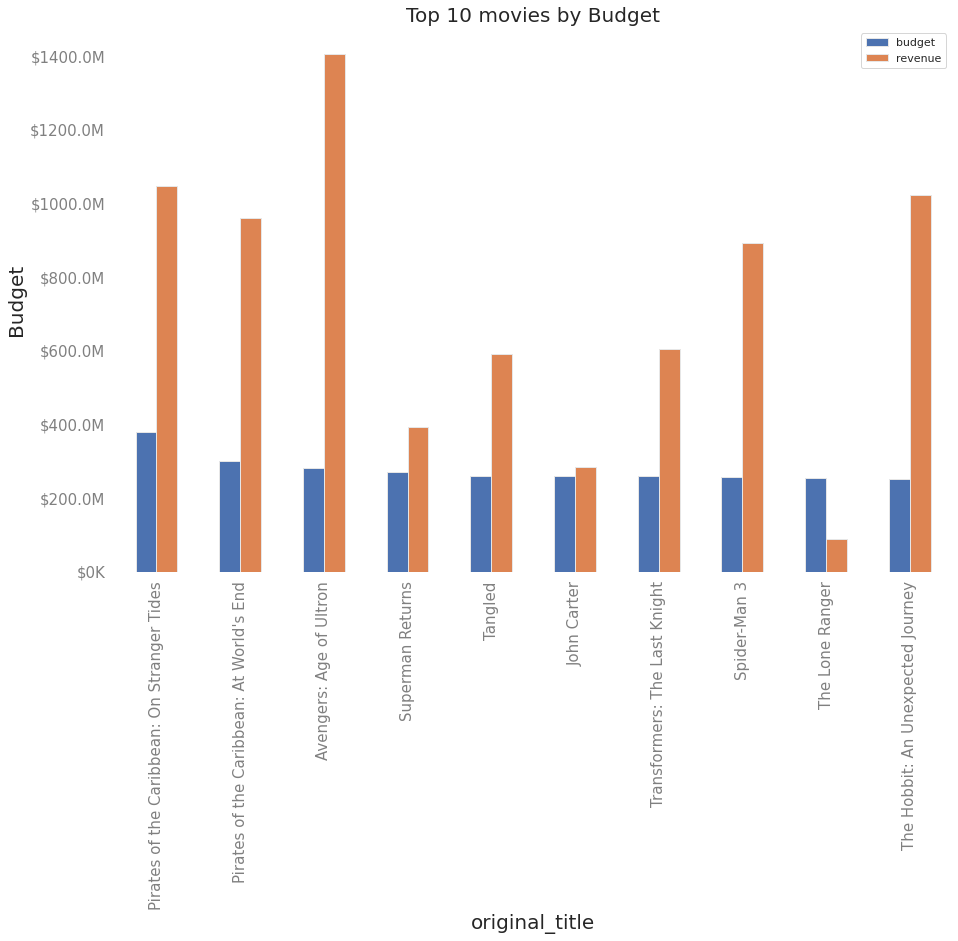

In [27]:
df_moviesBybudget=df.select('id_ori','original_title','budget','revenue').orderBy(col('budget'),ascending=False)

#convert to Pandas dataframe
df_pd_top15moviesBybudget=df_moviesBybudget.toPandas().head(10)


def currency(x, pos):
    'The two args are the value and tick position'
    if x >= 1000000:
        return '${:1.1f}M'.format(x*1e-6)
    return '${:1.0f}K'.format(x*1e-3)



ax=df_pd_top15moviesBybudget.plot(x="original_title", y=["budget","revenue"],kind="bar",figsize=(15, 10))
formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('original_title',fontsize=20)
ax.set_ylabel('Budget',fontsize=20)
ax.set_title('Top 10 movies by Budget',fontsize=20, loc='center')
plt.show()


<a id="4.8"></a> <br>
<h2>Top 10 movies by Revenue</h2>

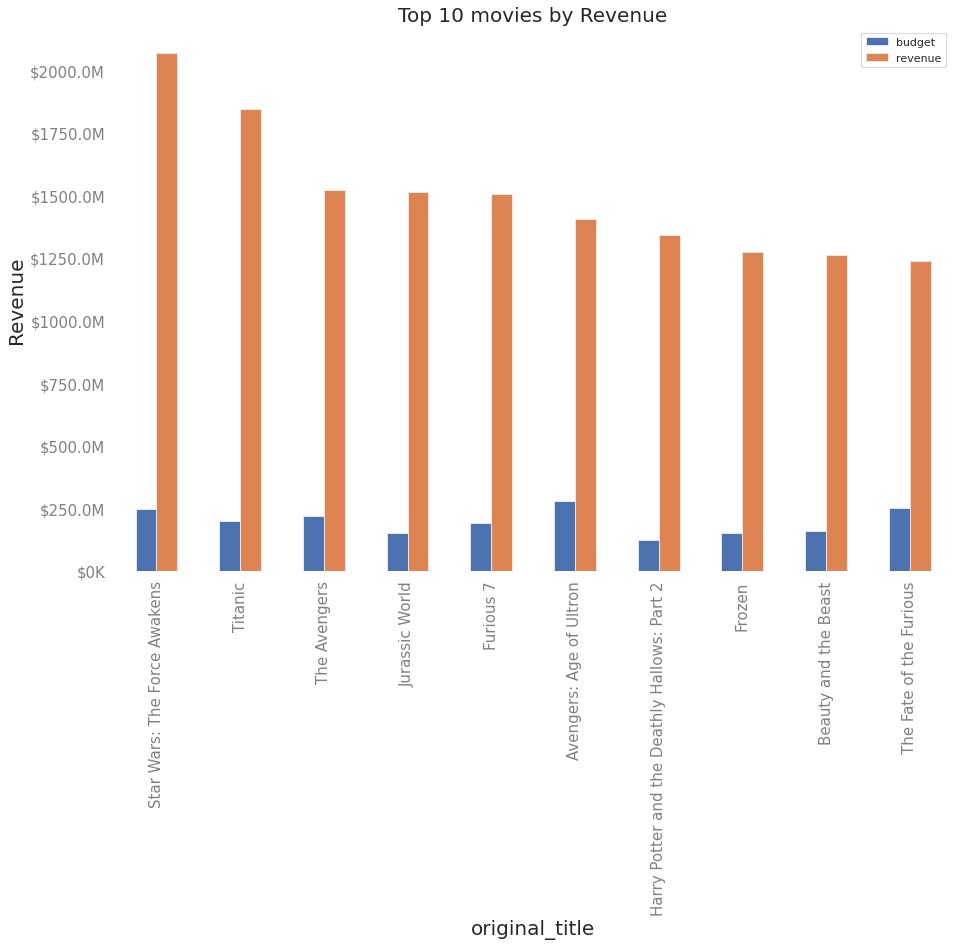

In [28]:
df_moviesByRevenue=df.select('id_ori','original_title','revenue','budget').orderBy(col('revenue'),ascending=False)

#convert to Pandas dataframe
df_pd_top15moviesByRevenue=df_moviesByRevenue.toPandas().head(10)

ax=df_pd_top15moviesByRevenue.plot(x="original_title", y=["budget","revenue"],kind="bar",figsize=(15, 10))
formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Top 10 movies by Revenue',fontsize=20, loc='center')
ax.set_xlabel('original_title',fontsize=20)
ax.set_ylabel('Revenue',fontsize=20)
plt.legend()
plt.show()

<a id="4.9"></a> <br>
<h2>Top 10 box office flops</h2>

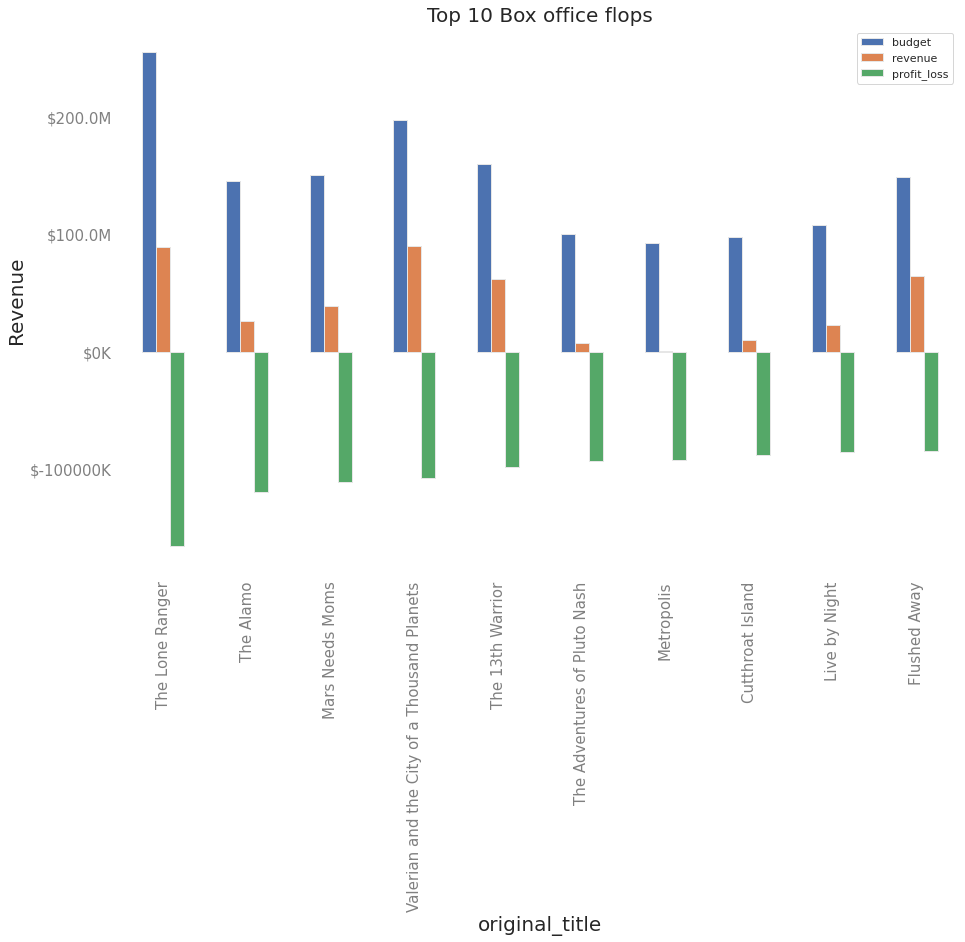

In [29]:
df_moviesByLoss=df.filter(col('revenue')>0)\
                  .withColumn("profit_loss",coalesce(col('revenue'),lit(0))-coalesce(col('budget'),lit(0)))\
                  .filter(col('profit_loss')<0)\
                  .select('id_ori','original_title','revenue','budget',"profit_loss").orderBy(col('profit_loss'),ascending=True)

df_pd_moviesByLoss=df_moviesByLoss.toPandas().head(10)

ax=df_pd_moviesByLoss.plot(x="original_title", y=["budget","revenue",'profit_loss'],kind="bar",figsize=(15, 10))
formatter = FuncFormatter(currency)
ax.yaxis.set_major_formatter(formatter)

ax.set_title('Top 10 Box office flops',fontsize=20, loc='center')
ax.set_xlabel('original_title',fontsize=20)
ax.set_ylabel('Revenue',fontsize=20)
plt.legend()
plt.show()

<a id="4.10"></a> <br>
<h2>Movies lauched by year</h2>

In [30]:
df_pd_moviesperYear=df.filter(col('release_date').isNotNull()).select('original_title','release_date',year(to_date(df.release_date,'yyyy-MM-dd')).alias('release_year'))\
                      .groupBy('release_year').count().toPandas()

df_pd_moviesperYear=df_pd_moviesperYear.fillna(0).astype({'release_year':int}).sort_values(by='release_year',ascending=True,inplace=False,ignore_index=True)


fig = px.bar(df_pd_moviesperYear, y='count', x='release_year', text='count',title='Number of Succesful Movies launched by year of the 20th Century')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_xaxes(
    range=[1900,2018],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)
fig.show()

In [33]:
df_pd_collection=df.where(col('name').isNotNull()).select(col('name')).groupBy(col('name')).count().orderBy(col('count').desc()).toPandas()
df_pd_collection.head(20)

,name,count
0,The Bowery Boys,29
1,Totò Collection,27
2,James Bond Collection,26
3,Zatôichi: The Blind Swordsman,26
4,The Carry On Collection,25
5,Pokémon Collection,20
6,Godzilla (Showa) Collection,16
7,Charlie Chan (Warner Oland) Collection,15
8,Dragon Ball Z (Movie) Collection,15
9,Monster High Collection,14


Word cloud for movie genre

In [34]:

genres_schema = ArrayType(StructType([
        StructField('id', StringType(), nullable=False), 
        StructField('name', StringType(), nullable=False)]))

df_wc=df.select(explode(from_json(col('genres'),genres_schema).getField("name").alias('genres_val')))
df_wc.groupby(col('col').alias('gener_values')).count().orderBy(col('count').desc()).show()

+---------------+-----+
|   gener_values|count|
+---------------+-----+
|          Drama|20243|
|         Comedy|13175|
|       Thriller| 7618|
|        Romance| 6730|
|         Action| 6590|
|         Horror| 4670|
|          Crime| 4304|
|    Documentary| 3930|
|      Adventure| 3490|
|Science Fiction| 3042|
|         Family| 2767|
|        Mystery| 2464|
|        Unknown| 2441|
|        Fantasy| 2309|
|      Animation| 1930|
|        Foreign| 1619|
|          Music| 1597|
|        History| 1398|
|            War| 1322|
|        Western| 1042|
+---------------+-----+
only showing top 20 rows



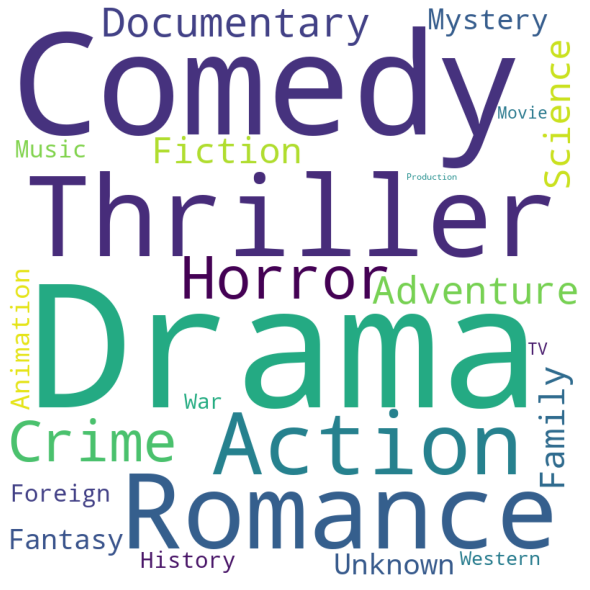

In [36]:
txt=df_wc.agg(concat_ws(',',collect_list(col('col'))).alias('wctxt')).toPandas()

wordcloud = WordCloud(width = 800, height = 800,background_color ='white',min_font_size = 10,collocations=False).generate(txt['wctxt'][0])
wordcloud.words_

# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [37]:
cast_schema=ArrayType(StructType([
  StructField('cast_id',IntegerType(),nullable=True),
  StructField('character',StringType(),nullable=True),
  StructField('credit_id',StringType(),nullable=True),
  StructField('gender',IntegerType(),nullable=True),
  StructField('id',IntegerType(),nullable=True),
  StructField('name',StringType(),nullable=True),
  StructField('order',IntegerType(),nullable=True),
  StructField('profile_path',StringType(),nullable=True)
]))

def update_cast(value):
    value = value.replace("'profile_path': None", "'profile_path': null")
    return value

convertUDF = udf(lambda z: update_cast(z)) 

credits = credits.withColumn("cast", convertUDF(col("cast")))
credits=credits.withColumn('movies_cast',from_json(col('cast'),cast_schema).getField("name").alias('movies_cast'))\
                .withColumn('director',regexp_extract(col('crew'),"(.)('job': 'Director', 'name': ')((\w+)(\s+)(\w+))(')",3))

credits.show()

+--------------------+--------------------+-----+--------------------+---------------+
|                cast|                crew|   id|         movies_cast|       director|
+--------------------+--------------------+-----+--------------------+---------------+
|[{'cast_id': 14, ...|[{'credit_id': '5...|  862|[Tom Hanks, Tim A...|  John Lasseter|
|[{'cast_id': 1, '...|[{'credit_id': '5...| 8844|[Robin Williams, ...|   Joe Johnston|
|[{'cast_id': 2, '...|[{'credit_id': '5...|15602|[Walter Matthau, ...|  Howard Deutch|
|[{'cast_id': 1, '...|[{'credit_id': '5...|31357|[Whitney Houston,...|Forest Whitaker|
|[{'cast_id': 1, '...|[{'credit_id': '5...|11862|[Steve Martin, Di...|  Charles Shyer|
|[{'cast_id': 25, ...|[{'credit_id': '5...|  949|[Al Pacino, Rober...|   Michael Mann|
|[{'cast_id': 1, '...|[{'credit_id': '5...|11860|[Harrison Ford, J...| Sydney Pollack|
|[{'cast_id': 2, '...|[{'credit_id': '5...|45325|[Jonathan Taylor ...|   Peter Hewitt|
|[{'cast_id': 1, '...|[{'credit_id': '5...|

In [38]:

credits_director=credits.where(col('director')!='').select('id','director')

df2_gener=df.where(col('genres_value')!='').select(col('id_ori'),'genres_value')

df_director=df2_gener.join(credits_director,credits_director.id==df2_gener.id_ori,how='inner').select('id','genres_value','director')

rdd2=df_director.select(col('genres_value')).rdd.flatMap(lambda x:x.genres_value.split(",")).distinct().collect()

exprs=[when(col('genres_value').contains(element),'1').otherwise('0').alias(element) for element in rdd2 ]

df_director=df_director.select(*df_director.columns, *exprs)
df_director.toPandas()

,id,genres_value,director,Animation,Comedy,Family,Adventure,Fantasy,Romance,Drama,...,History,Science Fiction,Mystery,War,Foreign,Unknown,Music,Documentary,Western,TV Movie
0,862,"Animation,Comedy,Family",John Lasseter,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8844,"Adventure,Fantasy,Family",Joe Johnston,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15602,"Romance,Comedy",Howard Deutch,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,31357,"Comedy,Drama,Romance",Forest Whitaker,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,11862,Comedy,Charles Shyer,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36008,30840,"Drama,Action,Romance",John Irvin,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
36009,439050,"Drama,Family",Hamid Nematollah,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
36010,111109,Drama,Lav Diaz,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
36011,227506,Unknown,Yakov Protazanov,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [39]:
expr={elements: "sum" for elements in df_director.columns[3:]}
tab_a=df_director.select(*[colc for colc in df_director.columns[2:]]).groupBy(col('director')).agg(expr)
tab_b=df_director.select(col('director')).groupBy(col('director')).agg(count('director').alias('filmcounts'))

tab_b.join(tab_a,['director']).orderBy(col('filmcounts').desc()).toPandas().head(10)

,director,filmcounts,sum(Animation),sum(Thriller),sum(War),sum(Horror),sum(Documentary),sum(Comedy),sum(Western),sum(Fantasy),...,sum(Drama),sum(Foreign),sum(History),sum(Music),sum(Mystery),sum(TV Movie),sum(Adventure),sum(Unknown),sum(Crime),sum(Action)
0,John Ford,66,0.0,1.0,10.0,0.0,2.0,16.0,21.0,0.0,...,38.0,0.0,6.0,0.0,1.0,0.0,9.0,1.0,4.0,9.0
1,Michael Curtiz,65,0.0,6.0,5.0,4.0,0.0,13.0,5.0,0.0,...,43.0,0.0,3.0,12.0,4.0,0.0,7.0,0.0,14.0,11.0
2,Werner Herzog,54,0.0,2.0,3.0,1.0,34.0,3.0,0.0,0.0,...,19.0,4.0,3.0,0.0,0.0,1.0,5.0,0.0,3.0,1.0
3,Alfred Hitchcock,53,0.0,34.0,4.0,2.0,0.0,6.0,0.0,0.0,...,30.0,0.0,0.0,1.0,22.0,0.0,2.0,1.0,17.0,2.0
4,Woody Allen,49,0.0,5.0,0.0,0.0,0.0,42.0,0.0,2.0,...,25.0,0.0,1.0,1.0,4.0,0.0,0.0,0.0,5.0,3.0
5,Sidney Lumet,46,0.0,14.0,1.0,0.0,1.0,7.0,0.0,1.0,...,40.0,0.0,3.0,1.0,5.0,0.0,1.0,1.0,13.0,5.0
6,Charlie Chaplin,44,0.0,0.0,1.0,0.0,0.0,43.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,Raoul Walsh,43,0.0,5.0,7.0,0.0,0.0,8.0,15.0,1.0,...,27.0,0.0,2.0,0.0,2.0,0.0,12.0,0.0,8.0,13.0
8,Henry Hathaway,42,0.0,8.0,7.0,0.0,0.0,2.0,13.0,0.0,...,20.0,0.0,3.0,1.0,1.0,0.0,5.0,0.0,8.0,12.0
9,Richard Thorpe,40,0.0,4.0,2.0,0.0,0.0,14.0,3.0,1.0,...,20.0,0.0,0.0,6.0,2.0,0.0,11.0,0.0,4.0,7.0


In [40]:
# Importing necessary libraries
import pandas as pd

# Loading the dataset
file_path = "/kaggle/input/top-500-hollywood-movies-of-all-time/Most Profitable Movies of All Time - Top 500 Movies.csv"
movies_df = pd.read_csv(file_path)

# Displaying the first few rows
movies_df.head()

,title,worldwide gross (m),% budget recovered,X times budget recovered,budget (millions),domestic gross (m),domestic %,international gross (m),% of gross from international,worldwide gross,year,decade,source,budget source,force label,horror
0,300,456.0,702%,7.0,65.0,211.0,46.2%,245.0,53.8%,456082343,2007,2000's,https://www.boxofficemojo.com/chart/ww_top_lif...,NaN,NaN,not horror
1,1917,385.0,427%,4.3,90.0,159.0,41.4%,225.0,58.6%,384576334,2019,2010's,https://www.boxofficemojo.com/chart/ww_top_lif...,https://www.nytimes.com/2020/01/12/movies/1917...,NaN,not horror
2,2012,791.0,396%,4.0,200.0,166.0,21.0%,625.0,79.0%,791217826,2009,2000's,https://www.boxofficemojo.com/chart/ww_top_lif...,NaN,NaN,not horror
3,101 Dalmatians,321.0,479%,4.8,67.0,136.0,42.5%,185.0,57.5%,320689294,1996,1990's,https://www.boxofficemojo.com/chart/ww_top_lif...,https://en.wikipedia.org/wiki/101_Dalmatians_(...,NaN,not horror
4,22 Jump Street,331.0,663%,6.6,50.0,192.0,57.9%,140.0,42.1%,331333876,2014,2010's,https://www.boxofficemojo.com/chart/ww_top_lif...,NaN,NaN,not horror


In [41]:
# Data Cleaning

# Checking for missing values
missing_values = movies_df.isnull().sum()

# Checking for duplicate rows
duplicate_rows = movies_df.duplicated().sum()

# Checking data types
data_types = movies_df.dtypes

missing_values, duplicate_rows, data_types


(title                              0
 worldwide gross (m)                0
 % budget recovered                 0
 X times budget recovered           0
 budget  (millions)                 0
 domestic gross (m)                 0
 domestic %                         0
 international gross (m)            0
 % of gross from international      0
 worldwide gross                    0
 year                               0
 decade                             0
 source                            81
 budget source                    163
 force label                      557
 horror                             0
 dtype: int64,
 0,
 title                             object
 worldwide gross (m)              float64
 % budget recovered                object
 X times budget recovered         float64
 budget  (millions)               float64
 domestic gross (m)               float64
 domestic %                        object
 international gross (m)          float64
 % of gross from international     ob

In [42]:
# Dropping the 'force label' column as it has a significant number of missing values
movies_df.drop(columns=['force label'], inplace=True)

# Converting percentage columns to numerical types by removing the percentage symbol and converting to float
percentage_columns = ['% budget recovered', 'domestic %', '% of gross from international']
for col in percentage_columns:
    movies_df[col] = movies_df[col].str.rstrip('%').astype('float') / 100

# Checking the first few rows after cleaning
movies_df.head()


,title,worldwide gross (m),% budget recovered,X times budget recovered,budget (millions),domestic gross (m),domestic %,international gross (m),% of gross from international,worldwide gross,year,decade,source,budget source,horror
0,300,456.0,7.02,7.0,65.0,211.0,0.462,245.0,0.538,456082343,2007,2000's,https://www.boxofficemojo.com/chart/ww_top_lif...,NaN,not horror
1,1917,385.0,4.27,4.3,90.0,159.0,0.414,225.0,0.586,384576334,2019,2010's,https://www.boxofficemojo.com/chart/ww_top_lif...,https://www.nytimes.com/2020/01/12/movies/1917...,not horror
2,2012,791.0,3.96,4.0,200.0,166.0,0.210,625.0,0.790,791217826,2009,2000's,https://www.boxofficemojo.com/chart/ww_top_lif...,NaN,not horror
3,101 Dalmatians,321.0,4.79,4.8,67.0,136.0,0.425,185.0,0.575,320689294,1996,1990's,https://www.boxofficemojo.com/chart/ww_top_lif...,https://en.wikipedia.org/wiki/101_Dalmatians_(...,not horror
4,22 Jump Street,331.0,6.63,6.6,50.0,192.0,0.579,140.0,0.421,331333876,2014,2010's,https://www.boxofficemojo.com/chart/ww_top_lif...,NaN,not horror


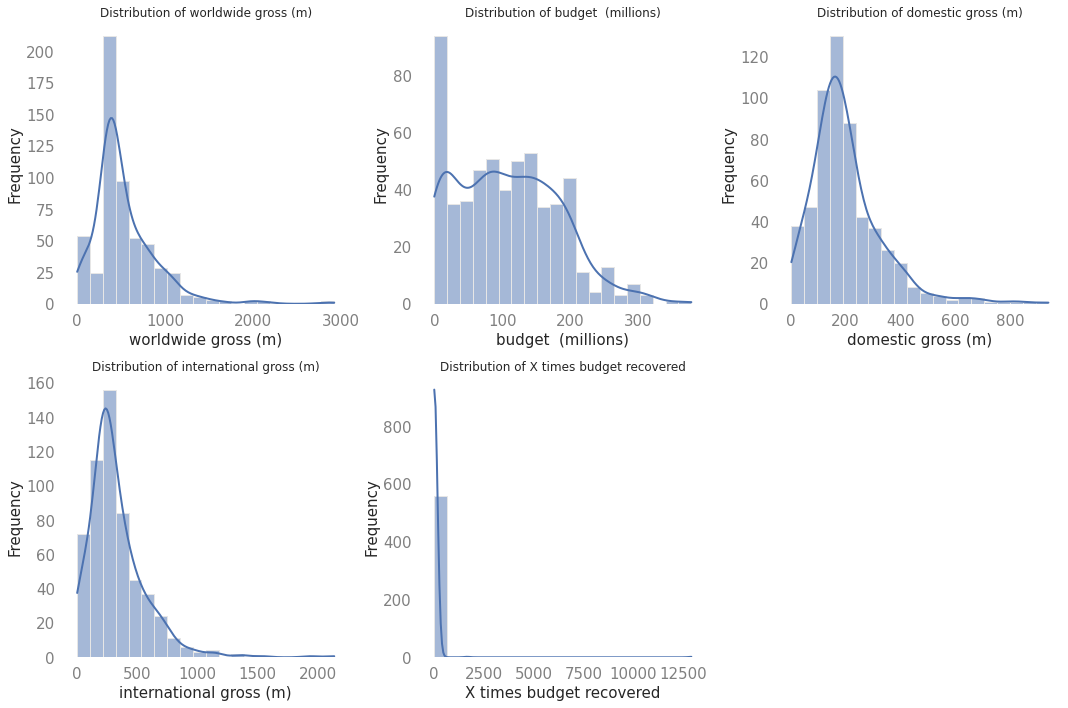

In [43]:
# EDA

import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical variables to plot
numerical_columns = [
    'worldwide gross (m)',
    'budget  (millions)',
    'domestic gross (m)',
    'international gross (m)',
    'X times budget recovered'
]

# Plotting histograms for the numerical variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(movies_df[col], bins=20, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


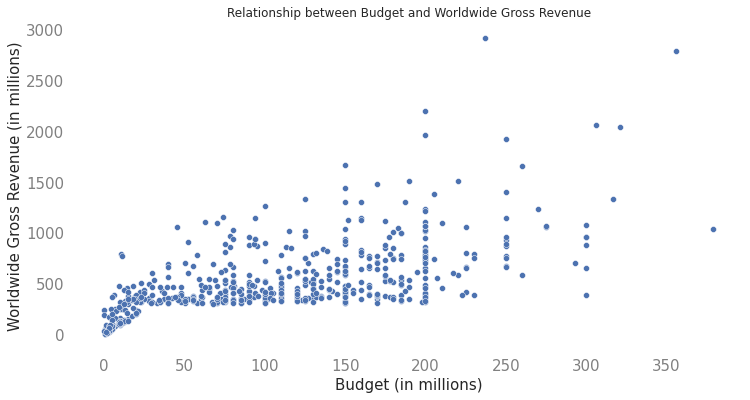

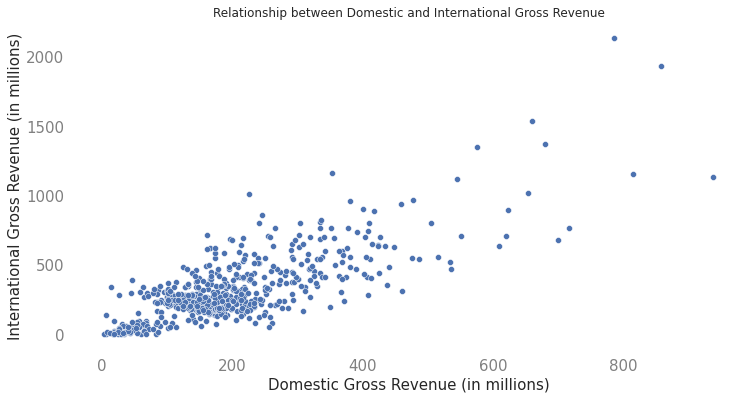

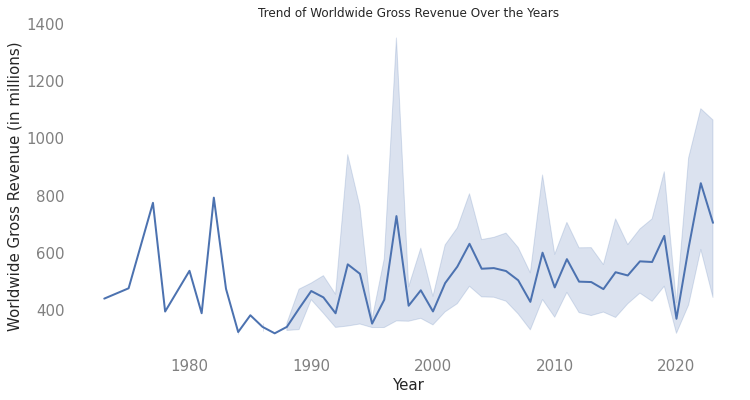

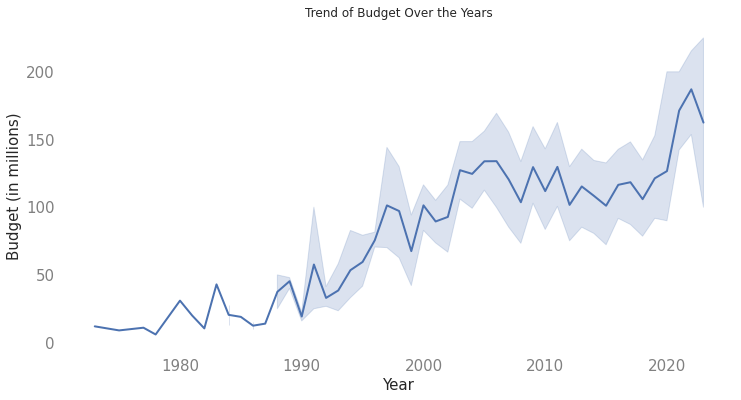

In [44]:
# Plotting the relationship between budget and worldwide gross revenue
plt.figure(figsize=(12, 6))
sns.scatterplot(x='budget  (millions)', y='worldwide gross (m)', data=movies_df)
plt.title('Relationship between Budget and Worldwide Gross Revenue')
plt.xlabel('Budget (in millions)')
plt.ylabel('Worldwide Gross Revenue (in millions)')
plt.show()

# Plotting the relationship between domestic and international gross revenue
plt.figure(figsize=(12, 6))
sns.scatterplot(x='domestic gross (m)', y='international gross (m)', data=movies_df)
plt.title('Relationship between Domestic and International Gross Revenue')
plt.xlabel('Domestic Gross Revenue (in millions)')
plt.ylabel('International Gross Revenue (in millions)')
plt.show()

# Plotting the trend of worldwide gross revenue over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='worldwide gross (m)', data=movies_df)
plt.title('Trend of Worldwide Gross Revenue Over the Years')
plt.xlabel('Year')
plt.ylabel('Worldwide Gross Revenue (in millions)')
plt.show()

# Plotting the trend of budget over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='budget  (millions)', data=movies_df)
plt.title('Trend of Budget Over the Years')
plt.xlabel('Year')
plt.ylabel('Budget (in millions)')
plt.show()


In [45]:
# K-means analysis

# to see if the movies tend to be organized in groups

from sklearn.cluster import KMeans

# Selecting the features for clustering
clustering_features_simple = ['budget  (millions)', 'worldwide gross (m)', '% of gross from international', 'year']
X_clustering_simple = movies_df[clustering_features_simple]

# Fitting k-means with 3 clusters
kmeans_simple = KMeans(n_clusters=2, init='k-means++', random_state=42)
movies_df['cluster'] = kmeans_simple.fit_predict(X_clustering_simple)

# Grouping the data by clusters to analyze the characteristics
cluster_summary_simple = movies_df.groupby('cluster').mean()[clustering_features_simple]
cluster_summary_simple['number_of_movies'] = movies_df['cluster'].value_counts()
print(cluster_summary_simple)


         budget  (millions)  worldwide gross (m)  \
cluster                                            
0                 88.382789           381.622222   
1                175.180769          1035.538462   

         % of gross from international         year  number_of_movies  
cluster                                                                
0                             0.573245  2008.877315               432  
1                             0.641123  2012.276923               130  


The optimal number of clusters (k) is: 2


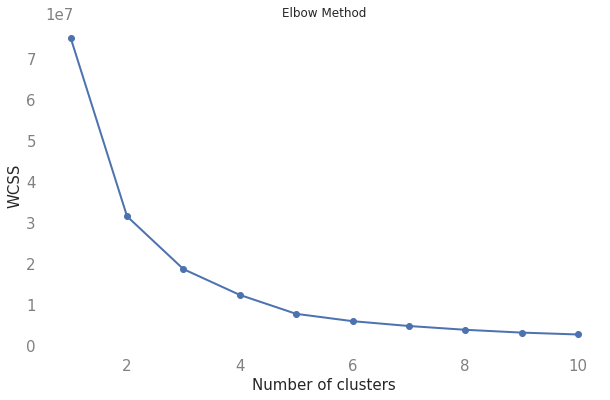

In [46]:
# Elbow method to check if we are using the best k value for k-means

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Selecting the features for clustering
clustering_features_simple = ['budget  (millions)', 'worldwide gross (m)', '% of gross from international', 'year']
X_clustering_simple = movies_df[clustering_features_simple]

# Finding the optimal number of clusters using the Elbow method
wcss = [] # Within-Cluster-Sum-of-Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_clustering_simple)
    wcss.append(kmeans.inertia_)

# Finding the optimal k by looking for the "elbow" point
# Calculating the second derivative of the WCSS
second_derivative = [0] + [wcss[i] - 2 * wcss[i + 1] + wcss[i + 2] for i in range(len(wcss) - 2)] + [0]

# The optimal k is where the second derivative is maximum
optimal_k = second_derivative.index(max(second_derivative)) + 1

print(f"The optimal number of clusters (k) is: {optimal_k}")

# Plotting the Elbow method graph (optional)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



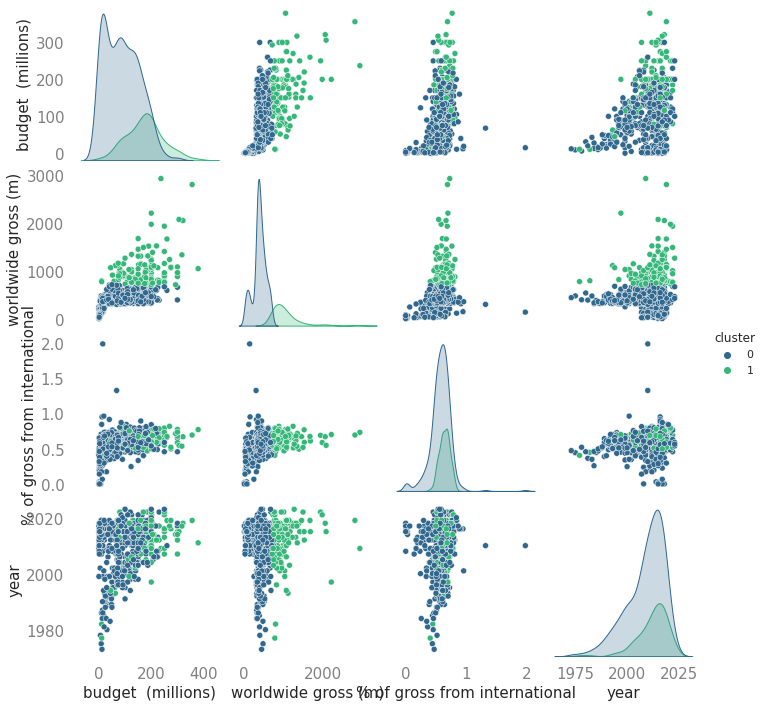

In [47]:
# Understanding the results of the k-means

import seaborn as sns

# Assuming you have already run the k-means clustering code
# Selecting the features used for clustering
clustering_features_all = ['budget  (millions)', 'worldwide gross (m)', '% of gross from international', 'year']
movies_df_clustering = movies_df[clustering_features_all + ['cluster']]

# Replacing the cluster labels with string labels for better visualization
movies_df_clustering['cluster'] = movies_df_clustering['cluster'].astype(str)

# Creating a pairplot to visualize all possible XY graphs of every k-means group
sns.pairplot(movies_df_clustering, hue='cluster', palette='viridis', diag_kind='kde')
plt.show()

In [48]:
# Worldwide Gross Revenue Predictor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Selecting features and target variable
features = ['budget  (millions)', 'year']
X = movies_df[features]
y = movies_df['worldwide gross (m)']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and fitting the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Calculating the mean squared error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 199.14025541472932


In [49]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split

# Loading the dataset again
movies_df = pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv', low_memory=False)

# Dropping rows where budget or revenue is 0 or NaN
movies_df = movies_df[movies_df['budget'].astype(str).str.isnumeric()]  # Ensuring budget values are numeric
movies_df['budget'] = movies_df['budget'].astype(float)
movies_df = movies_df[(movies_df['budget'] > 0) & (movies_df['revenue'] > 0)]

# Creating the ROI column
movies_df['ROI'] = (movies_df['revenue'] - movies_df['budget']) / movies_df['budget']

# Creating the success category column based on ROI
movies_df['success_category'] = 'Flop'
movies_df.loc[movies_df['ROI'] > 1, 'success_category'] = 'Success'
movies_df.loc[movies_df['ROI'] > 2, 'success_category'] = 'Major Success'

# Extracting the main genre for each movie
def extract_main_genre(genres_str):
    try:
        genres_list = json.loads(genres_str.replace("'", "\""))
        # Ensuring "Science Fiction" remains intact
        genres_names = [genre['name'] for genre in genres_list]
        for name in genres_names:
            if 'Science Fiction' in name:
                return 'Science Fiction'
        return genres_names[0]
    except:
        return 'Unknown'

movies_df['main_genre'] = movies_df['genres'].apply(extract_main_genre)

# Extracting the main production country for each movie
def extract_main_country(countries_str):
    try:
        countries_list = json.loads(countries_str.replace("'", "\""))
        return countries_list[0]['iso_3166_1']
    except:
        return 'Unknown'

movies_df['main_production_country'] = movies_df['production_countries'].apply(extract_main_country)

# Displaying the first few rows with the new columns
movies_df[['title', 'budget', 'revenue', 'ROI', 'success_category', 'main_genre', 'main_production_country']].head()


,title,budget,revenue,ROI,success_category,main_genre,main_production_country
0,Toy Story,30000000.0,373554033.0,11.451801,Major Success,Animation,US
1,Jumanji,65000000.0,262797249.0,3.043035,Major Success,Adventure,US
3,Waiting to Exhale,16000000.0,81452156.0,4.090760,Major Success,Comedy,US
5,Heat,60000000.0,187436818.0,2.123947,Major Success,Action,US
8,Sudden Death,35000000.0,64350171.0,0.838576,Flop,Action,US


In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Defining the features and target variable for regression
X_reg = movies_df[['budget', 'main_genre', 'main_production_country']]
y_reg = movies_df['revenue']

# Splitting the data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Building preprocessing pipelines
numerical_transformer_reg = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer_reg = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Preprocessing using ColumnTransformer
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_reg, ['budget']),
        ('cat', categorical_transformer_reg, ['main_genre', 'main_production_country'])
    ])

# Creating the Random Forest regressor pipeline
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor_reg),
                               ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
                              ])

# Training the regression model
reg_pipeline.fit(X_train_reg, y_train_reg)

# Predicting on the test set
y_pred_reg = reg_pipeline.predict(X_test_reg)

# Evaluating the regressor's performance using Mean Absolute Error (MAE)
mae_reg = mean_absolute_error(y_test_reg, y_pred_reg)

mae_reg

58689141.586066216

In [55]:
#print 5 random predictions

import pandas as pd

sample_df = movies_df.sample(n=2000)

X_sample = sample_df[['budget', 'main_genre', 'main_production_country']]
y_pred = reg_pipeline.predict(X_sample)

results = sample_df[['title', 'budget', 'main_genre', 'main_production_country', 'revenue']].copy()
results['predicted_revenue'] = y_pred
results['abs_error'] = (results['revenue'] - results['predicted_revenue']).abs()

final5 = filtered.sample(n=5, random_state=42)

cols = [
    'title',
    'budget',
    'main_genre',
    'main_production_country',
    'revenue',            # actual
    'predicted_revenue',  # predicted
    'abs_error'           # error
]
print(final5[cols].to_string(index=False))

                    title    budget main_genre main_production_country    revenue  predicted_revenue    abs_error
    It's a Wonderful Life 3180000.0      Drama                      US  9644124.0       9.581691e+06 62433.127818
                  Charlie 1900000.0      Drama                      IN  5900000.0       5.936116e+06 36115.800000
       She Done Him Wrong  200000.0     Comedy                      US  2200000.0       2.236245e+06 36245.037500
             The Gauntlet 5500000.0      Drama                      US 26414658.0       2.638990e+07 24761.303349
Blue Is the Warmest Color 4300000.0    Romance                      FR 10165694.0       1.018329e+07 17594.835000
